# **Импорты и Загрузка из SQLite**

In [1]:
!pip install pymorphy3 gensim scikit-learn nltk

In [2]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import pymorphy3

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from pymorphy3 import MorphAnalyzer

import re
import nltk
from nltk.corpus import stopwords

# **1. Загрузка данных из SQLite в pandas**

In [3]:
DB_FILE = "articles.db"

# Открываем соединение с SQLite
conn = sqlite3.connect(DB_FILE)

# Читаем всю таблицу articles в DataFrame
df = pd.read_sql_query("SELECT * FROM articles", conn)

# Закрываем соединение
conn.close()

print(f"Количество строк: {len(df)}")
print("Пример данных:")
df


Количество строк: 5000
Пример данных:


,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,4d256733-c8fa-45ee-bf52-b7faef8269ae,Первая в мире линия сборки аккумуляторных бата...,Компания CATL объявила о запуске первой в мире...,https://www.ixbt.com/news/2025/12/19/pervaja-v...,2025-12-19,0,2025-12-19T11:08:02.767781,0.0
1,7fb1723d-9220-4d1d-a878-c847f94ea93e,«Аномалия» Starlink: спутник потерял связь и н...,"На спутнике Starlink-35956, запущенном всего м...",https://www.ixbt.com/news/2025/12/19/anomalija...,2025-12-19,0,2025-12-19T11:08:03.207605,0.0
2,0fcff696-6f38-46c0-be86-e8318a815dc3,За регистрацию смартфонов в единой базе IMEI п...,В России намерены установить плату за обязател...,https://www.ixbt.com/news/2025/12/19/za-regist...,2025-12-19,0,2025-12-19T11:08:03.707268,0.0
3,83fa6ab0-cae1-4f36-ac42-bf84348dfa06,«Ведьмак» обойдётся без ИИ: разработчики утвер...,"Компания CD Projekt Red заявляет, что искусств...",https://www.ixbt.com/news/2025/12/19/cd-projek...,2025-12-19,0,2025-12-19T11:08:04.275748,0.0
4,e6f859ce-5bea-44d3-b715-2411f7524798,«Альфа-Банк» с оплатой через iPhone снова в Ap...,Приложение «Альфа-Банка» снова появилось в App...,https://www.ixbt.com/news/2025/12/19/iphone-ap...,2025-12-19,0,2025-12-19T11:08:04.771423,0.0
...,...,...,...,...,...,...,...,...
4995,d4881c5a-a355-4130-8ff9-4897e480a105,Илон Маск обещает выпустить игру с генеративны...,"Илон Маск объявил, что игровое подразделение x...",https://www.ixbt.com/news/2025/10/07/studija-i...,2025-10-07,0,2025-12-19T12:35:01.766489,0.0
4996,c0af00f2-b189-4d09-a09b-ef40833242ca,Сборка в России дала результат? Voyah Free ста...,Гибридный кроссовер Voyah Free возглавил сегме...,https://www.ixbt.com/news/2025/10/07/sborka-v-...,2025-10-07,0,2025-12-19T12:35:02.580680,0.0
4997,15078a01-36fa-44cc-afb9-efef7bf461b6,Лучшее из двух миров: первый гибридный телефон...,Компания HMD представила новый класс своей про...,https://www.ixbt.com/news/2025/10/07/hmd-touch...,2025-10-07,0,2025-12-19T12:35:03.550571,0.0
4998,9fa5525e-7b71-43a7-828d-bcbed25e038e,"Китайцы сильно оторвались, теперь Tesla поможе...",BYD обогнала Tesla по мировым продажам электро...,https://www.ixbt.com/news/2025/10/07/kitajcy-s...,2025-10-07,0,2025-12-19T12:35:04.001516,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   guid            5000 non-null   object 
 1   title           5000 non-null   object 
 2   description     5000 non-null   object 
 3   url             5000 non-null   object 
 4   published_at    5000 non-null   object 
 5   comments_count  5000 non-null   int64  
 6   created_at_utc  5000 non-null   object 
 7   rating          5000 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 312.6+ KB


Приведём строковые даты к datetime, чтобы с ними можно было работать как с временными признаками.
Это не обязательно для текстовой части, но полезно для полноты примера.

In [5]:
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df["created_at_utc"] = pd.to_datetime(df["created_at_utc"], errors="coerce")

df[["published_at", "created_at_utc"]].head()

,published_at,created_at_utc
0,2025-12-19,2025-12-19 11:08:02.767781
1,2025-12-19,2025-12-19 11:08:03.207605
2,2025-12-19,2025-12-19 11:08:03.707268
3,2025-12-19,2025-12-19 11:08:04.275748
4,2025-12-19,2025-12-19 11:08:04.771423


Посмотрим распределение рейтинга и пропусков в comments_count.

Пропуски в comments_count: 0
Пропуски в rating: 0


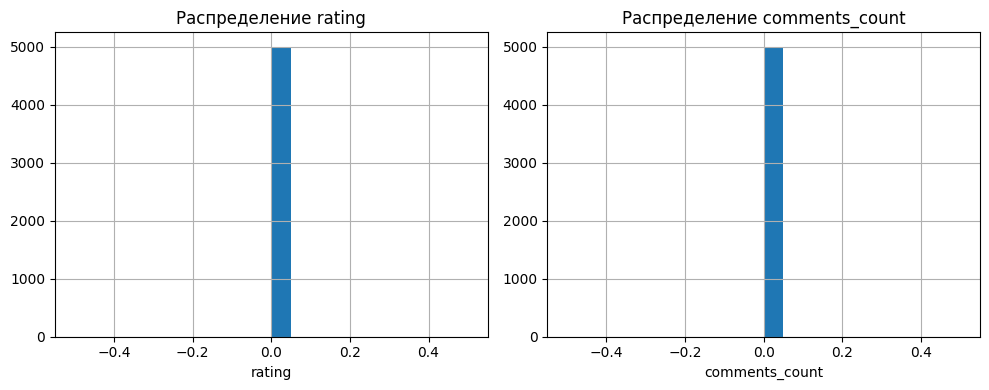

In [6]:
print("Пропуски в comments_count:", df["comments_count"].isna().sum())
print("Пропуски в rating:", df["rating"].isna().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df["rating"].hist(ax=axes[0], bins=20)
axes[0].set_title("Распределение rating")
axes[0].set_xlabel("rating")

df["comments_count"].hist(ax=axes[1], bins=20)
axes[1].set_title("Распределение comments_count")
axes[1].set_xlabel("comments_count")

plt.tight_layout()
plt.show()


In [7]:
# Скачаем русские стоп-слова NLTK (один раз)
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Предобработка текста**

# **2.1. Общая схема**
Привести текст к нижнему регистру.

Оставить только буквы ([А-Яа-яA-Za-z]+).

Разбить на токены (слова).

Удалить стоп-слова и короткие токены.

Для каждого слова получить лемму через pymorphy3.

Так мы уменьшаем размерность словаря и «склеиваем» разные формы слова.

P.S. pymorphy3 работает только с русскими словами, английские будем оставлять как есть.

In [8]:
# Инициализируем морфоанализатор и список стоп-слов
morph = pymorphy3.MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

# Регулярка для выделения слов (русские и латинские буквы)
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)

def preprocess_text(text: str):
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2: continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)
    return lemmas

Проверим функцию на одном примере (из первых описаний).

In [9]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]


Компания CATL объявила о запуске первой в мире производственной линии по сборке аккумуляторных батар ...


['компания',
 'catl',
 'объявить',
 'запуск',
 'первый',
 'мир',
 'производственный',
 'линия',
 'сборка',
 'аккумуляторный',
 'батарея',
 'который',
 'крупный',
 'масштаб',
 'задействовать',
 'человекоподобный',
 'робот',
 'линия',
 'начало',
 'работа',
 'база',
 'catl',
 'zhongzhou',
 'стать',
 'важный',
 'этап',
 'развитие',
 'интеллектуальный',
 'производство',
 'аккумулятор',
 'ключевой',
 'роль',
 'линия',
 'играть',
 'гуманоидный',
 'робот',
 'xiao',
 'способный',
 'стабильно',
 'выполнять',
 'высокоточный',
 'операция',
 'включая',
 'установка',
 'батарейный',
 'разъ',
 'мов',
 'маркировка',
 'компонент',
 'робот',
 'работать',
 'база',
 'модель',
 'vision',
 'language',
 'action',
 'который',
 'объединять',
 'зрительный',
 'восприятие',
 'понимание',
 'команда',
 'выполнение',
 'действие',
 'обеспечивать',
 'адаптация',
 'меняться',
 'условие',
 'универсальность',
 'решение',
 'задача',
 'catl',
 'отмечать',
 'внедрение',
 'решение',
 'открывать',
 'новый',
 'этап',
 'автомати

# **2.2. Применение к корпусу**

In [10]:
N_DOCS = 15000  # для демонстрации; нужно увеличить до len(df)

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['компания',
 'catl',
 'объявить',
 'запуск',
 'первый',
 'мир',
 'производственный',
 'линия',
 'сборка',
 'аккумуляторный',
 'батарея',
 'который',
 'крупный',
 'масштаб',
 'задействовать',
 'человекоподобный',
 'робот',
 'линия',
 'начало',
 'работа',
 'база',
 'catl',
 'zhongzhou',
 'стать',
 'важный',
 'этап',
 'развитие',
 'интеллектуальный',
 'производство',
 'аккумулятор',
 'ключевой',
 'роль',
 'линия',
 'играть',
 'гуманоидный',
 'робот',
 'xiao',
 'способный',
 'стабильно',
 'выполнять']

# **3. Обучение Word2Vec и векторизация документов**

# 3.1. Интуиция Word2Vec

Идея Word2Vec:

Если два слова часто встречаются в похожих контекстах, их смыслы близки → их векторы должны быть близки в векторном пространстве.

То есть модель не знает грамматики и словарей, она просто учится по статистике совместных появлений слов в окне контекста.

Две основные архитектуры:

CBOW (Continuous Bag-of-Words) — пытается по контексту предсказать слово.

Skip-gram — наоборот, по слову предсказывает слова контекста.
На практике:

CBOW быстрее и лучше для частых слов.

Skip-gram лучше ловит редкие слова, но обучается медленнее.

В gensim это переключается флагом sg:

sg=0 → CBOW

sg=1 → Skip-gram

# **3.2. Основные гиперпараметры Word2Vec**

vector_size — размерность вектора слова (обычно 100–300).

Больше размерность → богаче представление, но, дольше обучать

window — «окно» контекста (в словах).

window=5 означает, что мы смотрим 5 слов слева и справа (до 10 слов контекста).

Большое окно → больше «тематическая» близость; маленькое окно → более синтаксическая.

min_count — минимальная частота слова, чтобы попасть в словарь.

Если min_count=5, все слова, встретившиеся < 5 раз, игнорируются.

Это сильно уменьшает размер словаря и шум от опечаток/редких форм.

workers — число потоков; влияет только на скорость обучения.

sg — режим (0 = CBOW, 1 = Skip-gram).

epochs — сколько «проходов» по корпусу сделать.

Слишком мало — модель «недоучится».

Слишком много — можно начать переобучаться под шум корпуса.

# **3.3. Обучение Word2Vec на наших текстах**
Мы используем:

vector_size=100 — компромисс между качеством и скоростью.

window=5 — типичное значение для общего языка.

min_count=5 — отфильтровываем очень редкие слова.

sg=1 — Skip-gram, чтобы лучше обрабатывать редкие слова.

epochs=10 — для небольшого корпуса этого обычно достаточно.

Важно: sentences=tokenized_texts — список списков лемм, которые мы получили на шаге предобработки.

In [11]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=tokenized_texts,  # список документов, каждый документ = список лемм
    vector_size=120,            # размерность эмбеддинга слова
    window=5,                   # ширина контекста
    min_count=5,                # игнорируем слова реже 5 раз
    workers=4,                  # параллельные потоки
    sg=1,                       # 1 = Skip-gram, 0 = CBOW
    epochs=10,                  # сколько раз пройтись по корпусу
)

w2v_model

Посмотрим, какие слова похожи на одно из ключевых слов корпуса.

In [12]:
w2v_model.wv.most_similar("этап", topn=10)

[('заключительный', 0.6344837546348572),
 ('заверша', 0.5571597814559937),
 ('уголок', 0.5525815486907959),
 ('завершить', 0.5419043898582458),
 ('подготовка', 0.531706690788269),
 ('знаменовать', 0.5252068638801575),
 ('стадия', 0.5237332582473755),
 ('фаза', 0.5224701166152954),
 ('ознаменовать', 0.5215086936950684),
 ('закрепление', 0.5205374360084534)]

# **3.2. Векторы документов**
Чтобы получить вектор документа, можно усреднить векторы всех слов, которые есть в словаре Word2Vec.

In [13]:
def document_vector(tokens, model: Word2Vec):
    """
    Строит вектор документа как среднее по векторам слов.
    Слова, которых нет в модели, игнорируются.
    Если нет ни одного слова, выдаём нулевой вектор.
    """
    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v_model) for tokens in tokenized_texts])
doc_vectors.shape

(5000, 120)

# **4. Снижение размерности через PCA**

# **4.1. Зачем PCA**
Word2Vec даёт векторы размерности 100 (или больше).

Для визуализации и некоторых алгоритмов удобно перейти к 2–3 измерениям.

Используем Principal Component Analysis (PCA):

линейный метод,

сохраняет как можно больше дисперсии,

часто используется как «быстрая» предобработка перед кластеризацией.

In [14]:
pca = PCA(n_components=2, random_state=42)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]

array([[0.38138443, 0.24541503],
       [0.63202137, 0.3658938 ],
       [0.28965634, 0.20602947],
       [0.31246865, 0.46536922],
       [0.21670887, 0.25471705]], dtype=float32)

Добавим полученные координаты к датафрейму, чтобы удобно было визуализировать и связывать с метаданными.

In [15]:
df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating,pca_x,pca_y
0,4d256733-c8fa-45ee-bf52-b7faef8269ae,Первая в мире линия сборки аккумуляторных бата...,Компания CATL объявила о запуске первой в мире...,https://www.ixbt.com/news/2025/12/19/pervaja-v...,2025-12-19,0,2025-12-19 11:08:02.767781,0.0,0.381384,0.245415
1,7fb1723d-9220-4d1d-a878-c847f94ea93e,«Аномалия» Starlink: спутник потерял связь и н...,"На спутнике Starlink-35956, запущенном всего м...",https://www.ixbt.com/news/2025/12/19/anomalija...,2025-12-19,0,2025-12-19 11:08:03.207605,0.0,0.632021,0.365894
2,0fcff696-6f38-46c0-be86-e8318a815dc3,За регистрацию смартфонов в единой базе IMEI п...,В России намерены установить плату за обязател...,https://www.ixbt.com/news/2025/12/19/za-regist...,2025-12-19,0,2025-12-19 11:08:03.707268,0.0,0.289656,0.206029
3,83fa6ab0-cae1-4f36-ac42-bf84348dfa06,«Ведьмак» обойдётся без ИИ: разработчики утвер...,"Компания CD Projekt Red заявляет, что искусств...",https://www.ixbt.com/news/2025/12/19/cd-projek...,2025-12-19,0,2025-12-19 11:08:04.275748,0.0,0.312469,0.465369
4,e6f859ce-5bea-44d3-b715-2411f7524798,«Альфа-Банк» с оплатой через iPhone снова в Ap...,Приложение «Альфа-Банка» снова появилось в App...,https://www.ixbt.com/news/2025/12/19/iphone-ap...,2025-12-19,0,2025-12-19 11:08:04.771423,0.0,0.216709,0.254717


# **5. Кластеризация документов с помощью DBSCAN**
# **5.1. Идея DBSCAN**
DBSCAN

Мы будем кластеризовать уже PCA-сжатые векторы (doc_vectors_2d), так как в 100-мерном пространстве DBSCAN может работать нестабильно.

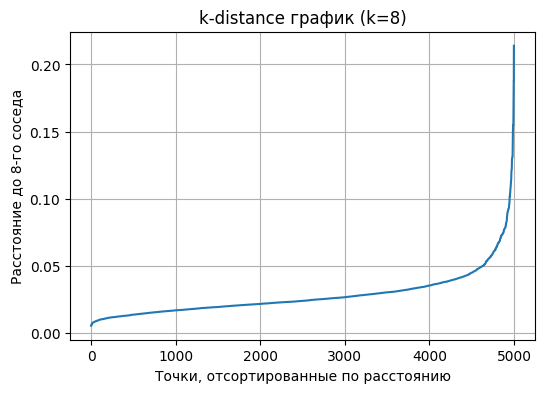

In [16]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

X_for_dbscan = doc_vectors_2d  # или другие признаки
k = 8  # это min_samples

# 1–2. считаем расстояния до k-го соседа
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_for_dbscan)
distances, indices = neigh.kneighbors(X_for_dbscan)

# расстояние до k-го соседа (столбец k-1)
k_distances = np.sort(distances[:, k-1])

# 3–4. строим график
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title(f"k-distance график (k={k})")
plt.xlabel("Точки, отсортированные по расстоянию")
plt.ylabel(f"Расстояние до {k}-го соседа")
plt.grid(True)
plt.show()

In [17]:
dbscan = DBSCAN(eps=0.03, min_samples=8)


cluster_labels = dbscan.fit_predict(doc_vectors_2d)

# -1 в DBSCAN означает "шум"
np.unique(cluster_labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 909, 1654, 1151,  306,  103,   42,   10,   14,   47,   11,  254,
          27,   21,   20,   19,   16,   14,   25,   18,   12,   13,   10,
          11,   24,    8,   11,    8,   10,   14,   30,   10,   11,   10,
          19,    2,   19,    4,    8,    5,    7,   10,    8,    9,    8,
          10,    8,   11,    6,    9,    6,    8]))

Добавим метку кластера в датафрейм и посмотрим пример.

In [18]:
df_subset["cluster"] = cluster_labels
df_subset[["title", "cluster"]].head(10)

,title,cluster
0,Первая в мире линия сборки аккумуляторных бата...,0
1,«Аномалия» Starlink: спутник потерял связь и н...,0
2,За регистрацию смартфонов в единой базе IMEI п...,0
3,«Ведьмак» обойдётся без ИИ: разработчики утвер...,0
4,«Альфа-Банк» с оплатой через iPhone снова в Ap...,0
5,Первый в мире мобильный телеобъектив Leica APO...,1
6,«Немецкая тройка» резко ускорилась в России: п...,2
7,Уникальное сочетание однокристальной системы S...,1
8,Тайвань закрепил технологический барьер для TS...,0
9,"Intel N95, 5 Гбит/с и до 72 ТБ данных — за 260...",1


Визуализация кластеров: каждой точке (документу) присвоим цвет кластера.

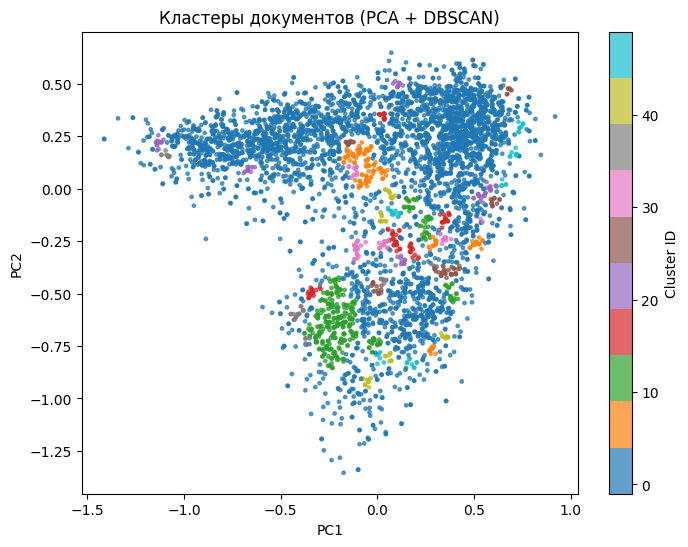

In [19]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов (PCA + DBSCAN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Можно посмотреть несколько документов из одного кластера, чтобы увидеть, объединяет ли их общая тема.

In [33]:
cluster_id = 3

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)

,title
15,Редчайший «Гелик» AMG из 90-х без пробега прод...
18,В России начнут собирать новые автомобили с оц...
227,"«Мы улучшили то, на что указывали наши клиенты..."
250,Таких «Москвичей» ещё не было. «Москвич М70» и...
340,Совершенно новая Toyota Corolla выходит 21 дек...
463,"Пневмоподвеска, 510 л.с., запас хода более 100..."
498,В России продают редчайший Aston Martin V8 Van...
507,Редчайший Lincoln Mark V в самой дорогой компл...
548,В России появилась альтернатива «Соболю NN 4WD...
618,Совершенно новый рамный внедорожник с 8-ступен...


# **6. Подготовка признаков для supervised-задачи**
Теперь будем решать задачу:

Научиться по признакам статьи предсказывать её кластер, полученный ранее алгоритмом DBSCAN.

Это типичный пример pseudo-labeling: мы сначала провели обучение без учителя (DBSCAN), получили кластерные метки, а затем используем их как «цель» в обучени с учителем обучении (Decision Tree, k-NN).

# **6.1. Что используем в качестве признаков**
Документный вектор из Word2Vec (doc_vectors, размерность 100).

Числовые признаки:

comments_count (с пропусками),
rating.

Для числовых признаков используем импьютацию (SimpleImputer, стратегия median), так как в comments_count есть NaN.

# **6.2. Что делаем с кластером -1**
DBSCAN помечает «шум» значением cluster = -1.

Для простоты будем исключать такие объекты из supervised-задачи, чтобы не пытаться учить модель предсказывать шум.

In [21]:
# Оставляем только объекты, которые DBSCAN отнёс к какому-то кластеру (cluster != -1)
mask_non_noise = df_subset["cluster"] != -1
df_sup = df_subset[mask_non_noise].copy()

print(
    "Всего объектов для supervised-задачи:",
    len(df_sup),
    "из",
    len(df_subset),
)

# Целевая переменная — номер кластера
y = df_sup["cluster"].astype(int)

y.value_counts().sort_index()


Всего объектов для supervised-задачи: 4091 из 5000


,count
cluster,
0,1654
1,1151
2,306
3,103
4,42
5,10
6,14
7,47
8,11


Подготовим числовые признаки (comments_count, rating) и выполним импьютацию пропусков.

In [22]:
numeric_features = df_sup[["comments_count", "rating"]].copy()

imputer = SimpleImputer(strategy="median")

numeric_imputed = imputer.fit_transform(numeric_features)
numeric_imputed[:5]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

Теперь соберём финальную матрицу признаков X:

первая часть: Word2Vec-векторы документов,

вторая часть: числовые признаки после импьютации.

Важно: использовать те же документные векторы, но взять только те строки, которые остались после фильтрации cluster != -1.

In [23]:
# Индексы документов, которые попали в df_sup
idx = df_sup.index.to_numpy()

# Берём соответствующие векторы документов
doc_vectors_sup = doc_vectors[idx]

# Собираем общий набор признаков
X = np.hstack([doc_vectors_sup, numeric_imputed])
X.shape

(4091, 122)

Разобьём данные на train и test с сохранением соотношения кластеров (stratify=y).

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

((3272, 122), (819, 122))

# **7. Обучение и оценка моделей (предсказание кластера)**
Обучим две классические модели:

Decision Tree (DecisionTreeClassifier);

k-Nearest Neighbors (k-NN) (KNeighborsClassifier).

Оценивать будем по:

accuracy,

classification_report (precision/recall/F1 по каждому кластеру).

Важно понимать, что качество здесь ограничено тем, насколько «читаемы» сами кластеры DBSCAN; иногда они могут пересекаться или быть слабо отделимыми.

In [25]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# **7.1. Decision Tree**

In [26]:
dt_clf = DecisionTreeClassifier(
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
)


dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

Decision Tree accuracy: 0.7948717948717948

Classification report (Decision Tree):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       331
           1       0.93      0.94      0.94       230
           2       0.78      0.69      0.73        61
           3       0.38      0.48      0.43        21
           4       0.17      0.12      0.14         8
           5       0.40      1.00      0.57         2
           6       0.00      0.00      0.00         3
           7       0.18      0.22      0.20         9
           8       0.00      0.00      0.00         2
           9       0.75      0.88      0.81        51
          10       0.40      0.40      0.40         5
          11       1.00      0.25      0.40         4
          12       0.00      0.00      0.00         4
          13       0.12      0.25      0.17         4
          14       0.00      0.00      0.00         3
          15       0.17      0.67      0.27         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **7.2. Подбор гиперпараметров k-NN через GridSearchCV**
Будем подбирать:

n_neighbors — число соседей,

weights — схема взвешивания голосов (uniform / distance),

metric — метрику расстояния (оставим cosine).

GridSearchCV будет:

использовать k-fold cross-validation (по умолчанию cv=5),

оптимизировать по метрике accuracy,

в конце вернёт best_estimator_, который мы проверим на тестовой выборке.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Базовый классификатор (без фиксированных гиперпараметров)
knn_base = KNeighborsClassifier()

# Сетка гиперпараметров для перебора
param_grid = {
    "n_neighbors": [3, 5, 10, 15, 25],
    "weights": ["uniform", "distance"],
    "metric": ["cosine", "euclidean"],
}

grid_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,          # 5-fold cross-validation
    n_jobs=-1,     # использовать все доступные ядра
    verbose=1,     # чтобы видеть прогресс
)


grid_knn.fit(X_train, y_train)

print("Лучшие параметры:", grid_knn.best_params_)
print("Лучший CV accuracy:", grid_knn.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Лучший CV accuracy: 0.8881438942969864


Используем найденный на кросс-валидации лучший классификатор и оценим его на тестовой выборке.

In [28]:
best_knn = grid_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

print("k-NN (best) accuracy на тесте:", accuracy_score(y_test, y_pred_knn))
print("\nClassification report (k-NN best):")
print(classification_report(y_test, y_pred_knn))

k-NN (best) accuracy на тесте: 0.905982905982906

Classification report (k-NN best):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       331
           1       0.95      0.99      0.97       230
           2       0.88      0.95      0.91        61
           3       0.81      0.62      0.70        21
           4       1.00      0.62      0.77         8
           5       1.00      1.00      1.00         2
           6       1.00      0.33      0.50         3
           7       0.67      0.67      0.67         9
           8       0.33      0.50      0.40         2
           9       0.77      0.96      0.85        51
          10       0.60      0.60      0.60         5
          11       1.00      1.00      1.00         4
          12       1.00      0.50      0.67         4
          13       1.00      0.50      0.67         4
          14       0.50      0.33      0.40         3
          15       1.00      0.67      0.80       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
